In [1]:
!pip install Spotipy

In [762]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2
import random
from functools import reduce

In [763]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util


cid ='' # Client ID; copy this from your app created on beta.developer.spotify.com
secret = '' # Client Secret; copy this from your app
username = '' # Your Spotify username
redirect_uri = 'https://example.com'

# Once the Authorisation is complete, we just need to `sp` to call the APIs
scope = 'user-top-read playlist-modify-public'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [ ]:
results = sp.current_user_top_tracks(limit=50, offset=0,time_range='medium_term')
results

In [ ]:
# Convert it to Dataframe
track_name = []
track_id = []
artist = []
artist_id = []
album = []
duration = []
popularity = []
for i, items in enumerate(results['items']):
        track_name.append(items['name'])
        track_id.append(items['id'])
        artist.append(items["artists"][0]["name"])
        artist_id.append(items["artists"][0]["id"])
        duration.append(items["duration_ms"])
        album.append(items["album"]["name"])
        popularity.append(items["popularity"])

# Create the final df   
df_favorite = pd.DataFrame({ "track_name": track_name, 
                             "album": album, 
                             "track_id": track_id,
                             "artist": artist, 
                             "artist_id": artist_id,
                             "duration": duration, 
                             "popularity": popularity})

df_favorite

In [766]:
def fetch_audio_features(sp, df):
    playlist = df[['track_id','track_name', 'artist_id']] 
    index = 0
    audio_features = []
    genres = []
    
    # Make the API request
    while index < playlist.shape[0]:
        audio_features += sp.audio_features(playlist.iloc[index:index + 50, 0])
        index += 50
        
    index = 0
    while index < playlist.shape[0]:
        genres += [sp.artist('spotify:artist:'+ playlist.iloc[index, 2])['genres']]
        index += 1
    
    # Create an empty list to feed in different charactieritcs of the tracks
    features_list = []
    #Create keys-values of empty lists inside nested dictionary for album
    for features in audio_features:
        features_list.append([features['danceability'],
                              features['acousticness'],
                              features['energy'], 
                              features['tempo'],
                              features['instrumentalness'], 
                              features['loudness'],
                              features['liveness'],
                              features['duration_ms'],
                              features['key'],
                              features['valence'],
                              features['speechiness'],
                              features['mode']
                             ])
    
    df_audio_features = pd.DataFrame(features_list, columns=['danceability', 'acousticness', 'energy','tempo', 
                                                             'instrumentalness', 'loudness', 'liveness','duration_ms', 'key',
                                                             'valence', 'speechiness', 'mode',])
    df_audio_features['genres'] = genres
    
    # Create the final df, using the 'track_id' as index for future reference
    df_playlist_audio_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_audio_features.set_index('track_name', inplace=True, drop=True)
    return df_playlist_audio_features

In [ ]:
df_fav = fetch_audio_features (sp, df_favorite)
df_fav

In [768]:
df_fav.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Flower Shops (feat. Morgan Wallen) to Fishin' in the Dark
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          50 non-null     object 
 1   artist_id         50 non-null     object 
 2   danceability      50 non-null     float64
 3   acousticness      50 non-null     float64
 4   energy            50 non-null     float64
 5   tempo             50 non-null     float64
 6   instrumentalness  50 non-null     float64
 7   loudness          50 non-null     float64
 8   liveness          50 non-null     float64
 9   duration_ms       50 non-null     int64  
 10  key               50 non-null     int64  
 11  valence           50 non-null     float64
 12  speechiness       50 non-null     float64
 13  mode              50 non-null     int64  
 14  genres            50 non-null     object 
dtypes: float64(9), int64(3), object(3)
memory usage:

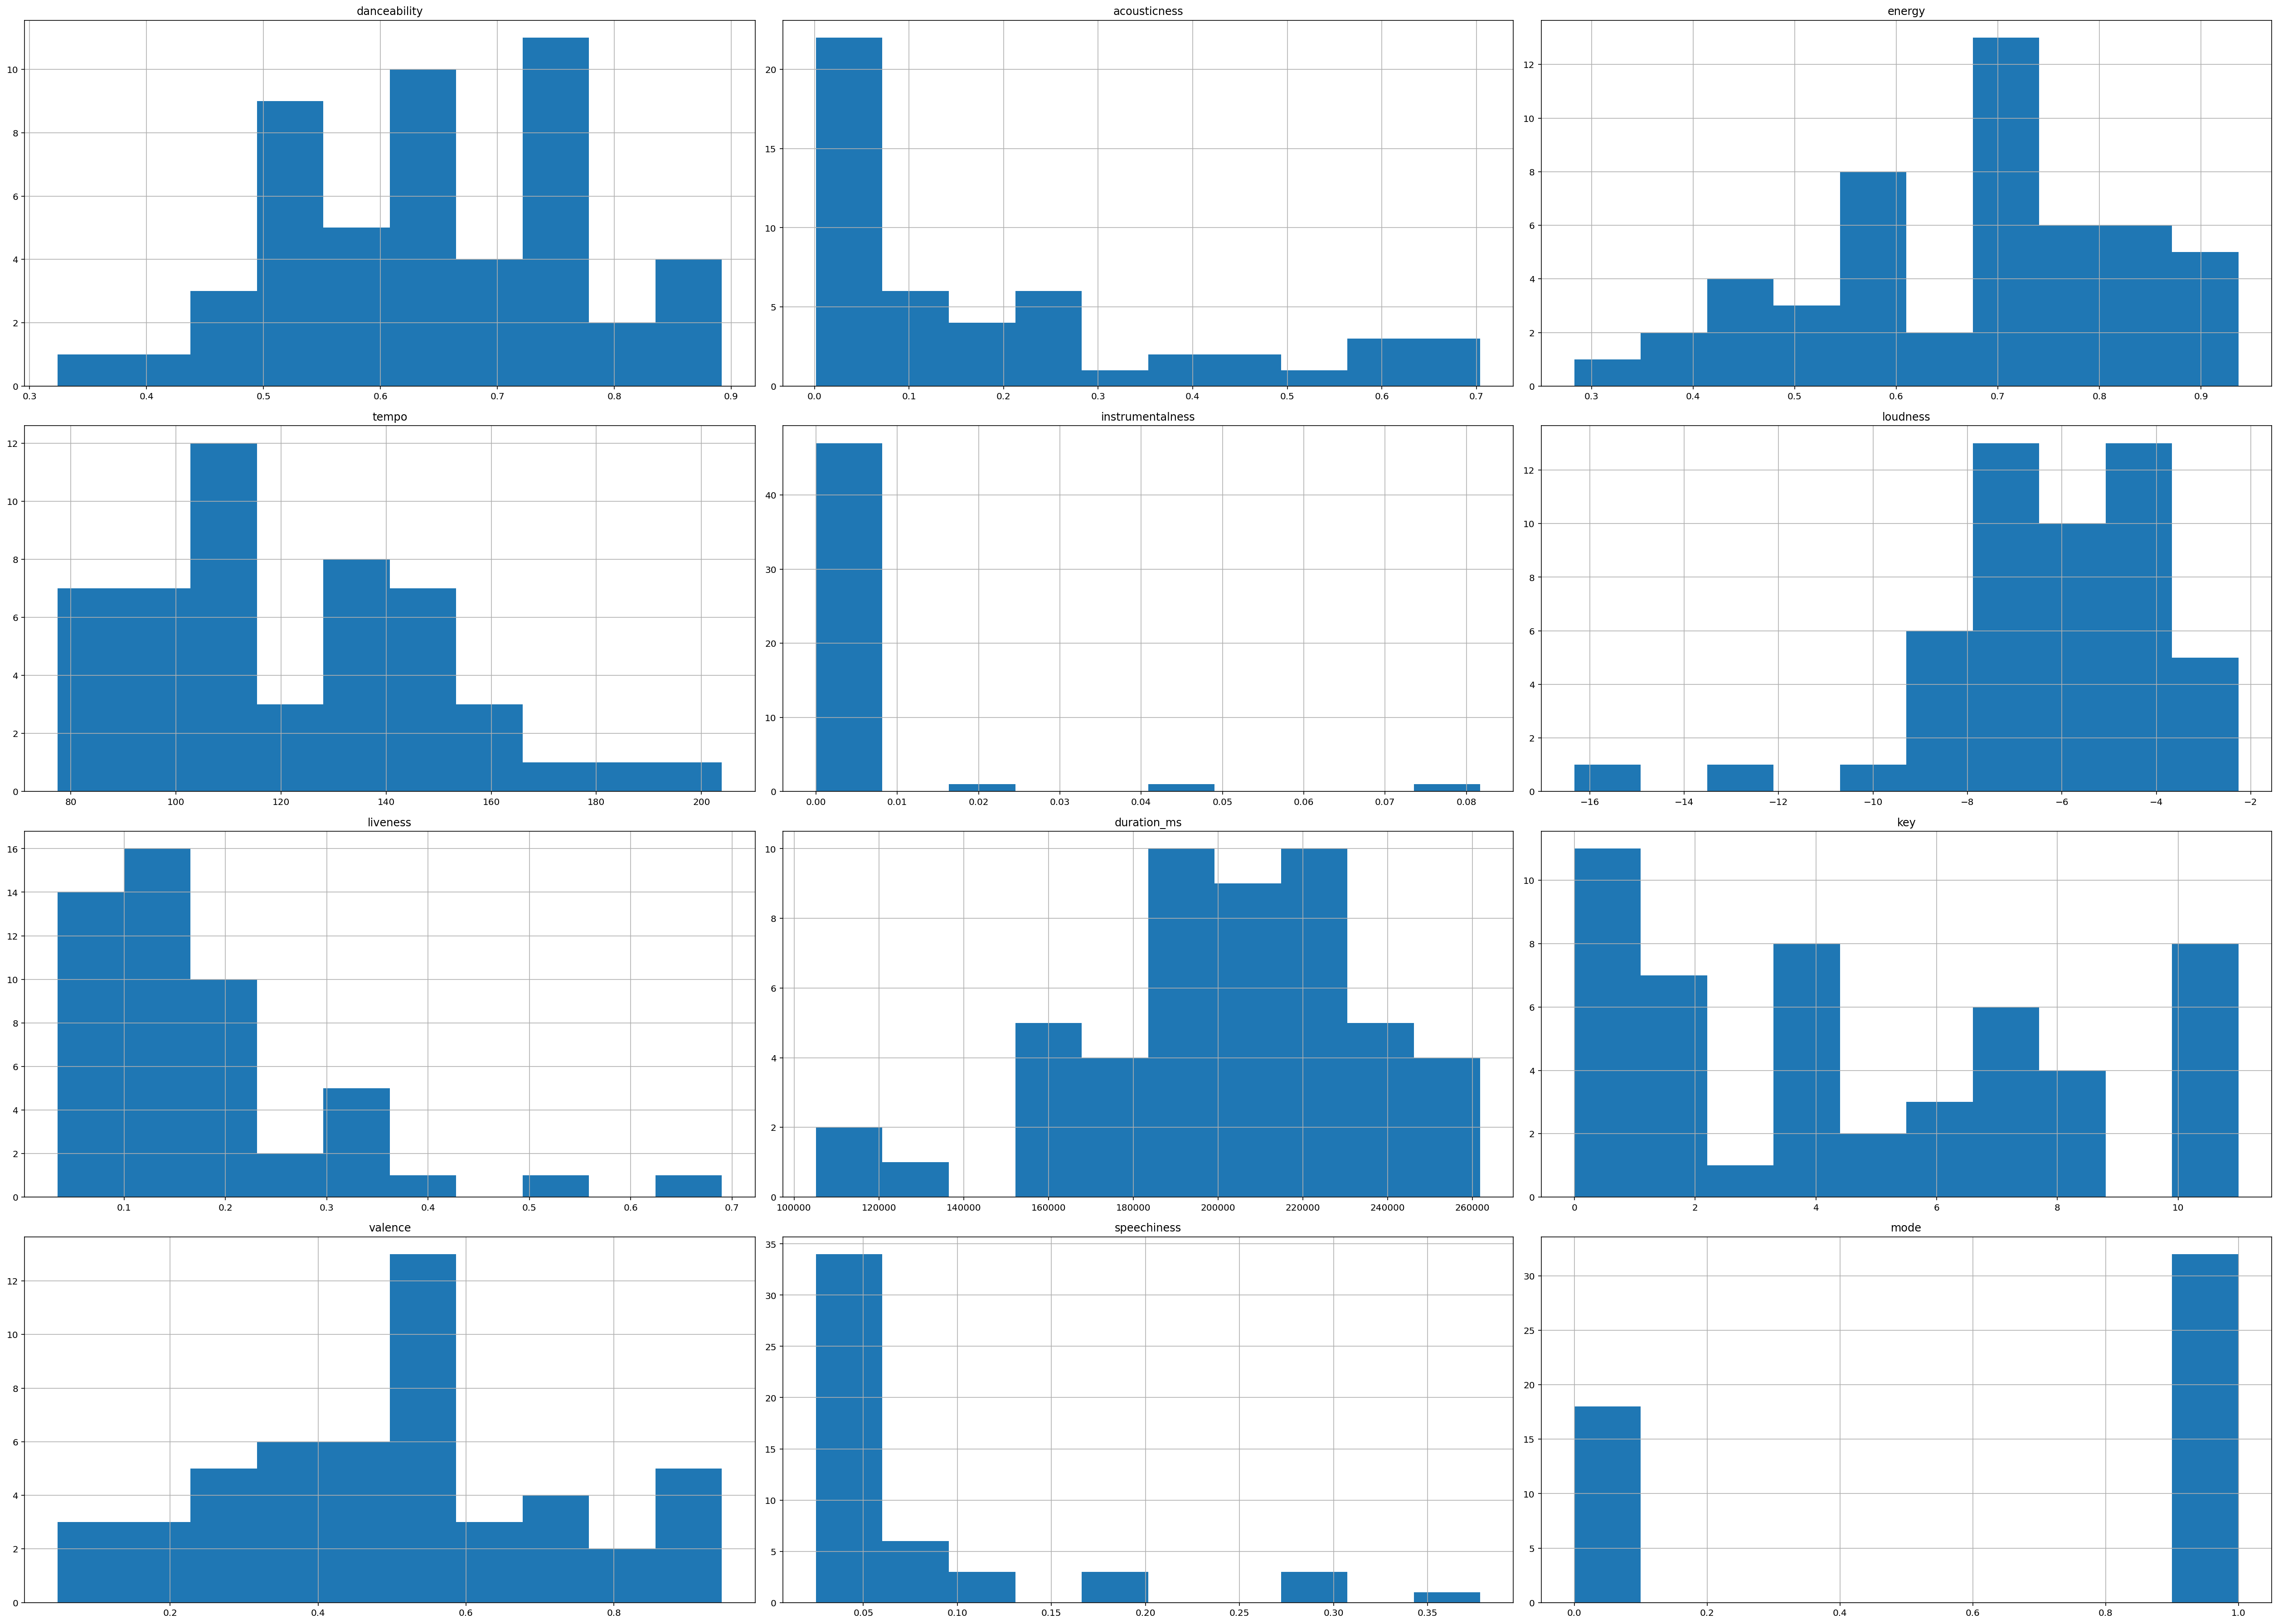

In [769]:
df_fav.hist(figsize=(35,25)) 
plt.tight_layout()
plt.show()

In [782]:
def featured_playlists(sp):
    id = []
    name = []
    num_tracks = []
 # For looping through the API request  
    playlists = sp.user_playlists('')#Replace with user id
    for i, items in enumerate(playlists['items']):
        id.append(items['id'])
        name.append(items['name'])
        num_tracks.append(items['tracks']['total'])

# Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [ ]:
df_playlists = featured_playlists(sp)
df_playlists

In [784]:
def fetch_playlist_tracks(sp, playlistsid): 
    offset = 0
    tracks = []
    # Make the API request
    while True:
            content = sp.playlist_tracks( playlistsid, fields=None, limit=100, offset=offset, market=None)
            tracks += content['items']
        
            if content['next'] is not None:
                offset += 100
            else:
                break
    
    track_id = []
    track_name = []
    
    for track in tracks:
        track_id.append(track['track']['id'])
        track_name.append(track['track']['name'])
    
# Create the final df
    df_playlists_tracks = pd.DataFrame({"track_id":track_id, "track_name": track_name})
    return df_playlists_tracks

In [785]:
def fetch_audio_features(sp, playlist_id):
    playlist = fetch_playlist_tracks(sp, playlist_id)
    index = 0
    audio_features = []
    
    # Make the API request
    while index < playlist.shape[0]:
        audio_features += sp.audio_features(playlist.iloc[index:index + 50, 0])
        index += 50
    
    # Create an empty list to feed in different charactieritcs of the tracks
    features_list = []
    #Create keys-values of empty lists inside nested dictionary for album
    for features in audio_features:
        features_list.append([features['danceability'],
                              features['acousticness'],
                              features['energy'], 
                              features['tempo'],
                              features['instrumentalness'], 
                              features['loudness'],
                              features['liveness'],
                              features['duration_ms'],
                              features['key'],
                              features['valence'],
                              features['speechiness']
                             ])
    
    df_audio_features = pd.DataFrame(features_list, columns=['danceability', 'acousticness', 'energy','tempo', 
                                                             'instrumentalness', 'loudness', 'liveness', 'duration_ms', 'key',
                                                             'valence', 'speechiness'])
    
    # Create the final df, using the 'track_id' as index for future reference
    df_playlist_audio_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_audio_features.set_index('track_name', inplace=True, drop=True)
    return df_playlist_audio_features

In [ ]:
# Build the dtaframe froms the playlists
for i, playlist in enumerate(df_playlists['id']):
    try:
        string_command = "df_{} = fetch_audio_features(sp, playlist)".format(playlist)
        print("Create {}".format(string_command))
        exec(string_command)
    except:
        print("playlist with id {} is not valid, skiping ".format(playlist))
        pass

In [787]:
def fetch_audio_features_mean(sp, playlist_id):
    Playlist = fetch_audio_features(sp, playlist_id)#df_playlist_audio_features(sp, playlist_id)
    return pd.DataFrame(Playlist.mean(), columns= [playlist_id])

In [788]:
# Merge them together
dataframes = []
# Loop through the filenames to populate dataframes with different dataframes 
for  i in df_playlists['id']:
    try:
        dataframes.append(fetch_audio_features_mean(sp, i))
    except:
        print ("Skip "+i)

In [789]:
dataframes

[                  3LifmvfEseGAVCzDO7zo3C
 danceability                    0.699882
 acousticness                    0.267400
 energy                          0.711882
 tempo                         125.786059
 instrumentalness                0.001361
 loudness                       -7.398176
 liveness                        0.151324
 duration_ms                232772.588235
 key                             5.647059
 valence                         0.755176
 speechiness                     0.047271,
                   44LM5IT4FH6KJ89WQapP5M
 danceability                    0.582344
 acousticness                    0.180672
 energy                          0.755344
 tempo                         129.680984
 instrumentalness                0.000139
 loudness                       -5.324148
 liveness                        0.136984
 duration_ms                214496.114754
 key                             5.262295
 valence                         0.586213
 speechiness                     

In [790]:
X = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dataframes)
X

,3LifmvfEseGAVCzDO7zo3C,44LM5IT4FH6KJ89WQapP5M,3Xt4aAEQAAJxAOsl4PRhjI,2cxO9sNFdDJ0jkOFJgtmjD,1hmOhTT9Ys7rZjNA99jLKw
danceability,0.699882,0.582344,0.622077,0.571140,0.506500
acousticness,0.267400,0.180672,0.213064,0.173250,0.350321
energy,0.711882,0.755344,0.733538,0.745884,0.566500
tempo,125.786059,129.680984,123.490795,125.007837,111.301000
instrumentalness,0.001361,0.000139,0.000300,0.000131,0.000154
loudness,-7.398176,-5.324148,-6.986256,-5.232000,-6.831500
liveness,0.151324,0.136984,0.162703,0.136960,0.117050
duration_ms,232772.588235,214496.114754,220021.205128,206695.883721,238042.857143
key,5.647059,5.262295,4.871795,5.837209,4.571429
valence,0.755176,0.586213,0.627513,0.567791,0.378929


In [791]:
Y = pd.DataFrame(df_fav.median(), columns= ['fav_playlist'])
Y= Y.drop('mode')
Y

,fav_playlist
danceability,0.6430
acousticness,0.1145
energy,0.7020
tempo,111.5545
instrumentalness,0.0000
loudness,-5.9065
liveness,0.1270
duration_ms,203625.5000
key,4.0000
valence,0.5020


In [ ]:
# Analyze feature importances
from sklearn.ensemble._forest import RandomForestRegressor
# Can combine step above with this
forest = RandomForestRegressor(n_estimators=10)#random_state=42, max_depth=2, max_features=9) 
forest.fit(X,Y.values.ravel())
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature rankings
print("Playlist ranking:")
  
for f in range(len(importances)):
    print("%d. %s %f " % (f + 1, 
            X.columns[indices[f]], 
            importances[indices[f]]))

In [ ]:
frames = []
for i, playlist in enumerate(df_playlists['id']):
    try:
        string_command = "frames.append(df_{})".format(playlist)
        print("Create {}".format(string_command))
        exec(string_command)
    except:
        print("playlist with id {} is not valid, skiping ".format(playlist))
        pass
print (frames)
df =pd.concat(frames)
df.drop_duplicates()
df

In [ ]:
df = df.set_index(['track_id'])
df

In [795]:
# CO
Y= Y.squeeze('columns')

In [796]:
Y = Y.sort_index( axis=0, level=None, ascending=True, inplace=False, kind='quicksort')
Y

acousticness             0.1145
danceability             0.6430
duration_ms         203625.5000
energy                   0.7020
instrumentalness         0.0000
key                      4.0000
liveness                 0.1270
loudness                -5.9065
speechiness              0.0456
tempo                  111.5545
valence                  0.5020
Name: fav_playlist, dtype: float64

In [ ]:
# Subtract mean of the favorite plalyist from the top 3 playlist 
df1= df.subtract(Y, axis='columns') 
df1

In [ ]:
df1= df1.divide(Y, axis='columns') 
df1

In [799]:
df1 = df1.drop(['instrumentalness'], axis=1)

In [ ]:
# Add all the score 
df1['variation'] = df1.sum(axis=1)
# take the absoulte of the variatio
df1['variation'] = df1['variation'].abs()
df1 = df1.drop_duplicates()
df1

In [ ]:
# Now we have the variation, we will take the songs with the least variation 
df2 = df1.nsmallest(50,'variation', keep='first')
df2

In [735]:
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [736]:
create_playlist(sp, username, 'JS Blend2', 'Test playlist created using python!')

In [737]:
def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [ ]:
fetch_playlists(sp,username)

In [739]:
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 50])
        index += 50

In [740]:
list_track = df2.index

In [741]:
enrich_playlist(sp, username, '', list_track) #playlist id

In [ ]:
fetch_playlists(sp,username)